In [2]:
import numpy as np
import random
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import time
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


In [3]:
def schaffer_function(mat_x_y, bound_values):
    min_mat = bound_values.T[0, :]
    max_mat = bound_values.T[1,:]
    mat_x_y_denorm = mat_x_y * (max_mat - min_mat) + min_mat
    x = mat_x_y_denorm[:, 0]
    y = mat_x_y_denorm[:, 1]
    g = 0.5 + (np.power((np.sin( np.sqrt( np.power(x, 2) + np.power(y, 2)))), 2) - 0.5)/ \
        (1 + 0.001 * (np.power(x, 2) + np.power(y, 2)))
    return g

100%|██████████| 400/400 [00:00<00:00, 7471.32it/s]

--- 0.055674076080322266 seconds ---


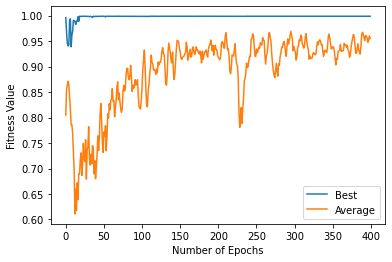

In [20]:
class DEPSO():
    def __init__(self,
                 num_epochs:int,
                 pop_size:int,
                 chrom_length:int,
                 n_best:int,
                 local_factor:float,
                 global_factor:float,
                 speed_factor:float,
                 v_max: float,
                 value_ranges:list,
                 crossover_rate:float,
                 fitness_func, # Function Type,
                 seed=42,
                 eval_every=100,
                 verbose = 0,
                 neighborhood_mode = "self",
                 maintain_history=False
                ):
        
        self.num_epochs = num_epochs
        self.pop_size = pop_size
        self.n_best = n_best
        self.chrom_length = chrom_length
        self.local_factor = local_factor
        self.global_factor = global_factor
        self.speed_factor = speed_factor
        self.crossover_rate = crossover_rate
        self.v_max = v_max
        self.value_ranges = np.array(value_ranges)
        self.fitness_func = fitness_func
        self.seed = seed    
        self.best_ind_list = np.zeros(self.num_epochs)
        self.avg_ind_list = np.zeros(self.num_epochs)
        self.eval_every = eval_every
        self.verbose = verbose
        self.f_g_best_alltime = 0
        self.neighborhood_mode = neighborhood_mode
        self.maintain_history=maintain_history
        self.particle_history = []
        self.pbest_history = []
        self.gbest_history = []
        self.speed_history = []

        self.min_mat = self.value_ranges.T[0, :]
        self.max_mat = self.value_ranges.T[1,:]

        np.random.seed(seed=seed)

        self.init_pop()
        self.calculate_fitness()
        self.update_gbest()
        self.update_pbest()
        self.update_speed()
        self.update_position()
        self.mutation()
        self.crossover()
        self.calculate_fitness()
        self.selection()


    def init_pop(self):
        self.x_i = np.random.rand(self.pop_size, self.chrom_length)
        self.v_i = np.random.rand(self.pop_size, self.chrom_length)
        self.v_i = self.v_i * (2 * self.v_max) - self.v_max
        self.f_x_i = self.fitness_func(self.x_i, self.value_ranges)
        self.f_gbest = self.f_x_i.max()
        #self.gbest = self.x_i[self.f_x_i == self.f_x_i.max()].squeeze(axis=0)
        self.gbest = self.x_i[self.f_x_i == self.f_x_i.max()]
        self.pbest = self.x_i.copy()
        self.f_pbest = self.f_x_i.copy()
        self.u_g = self.x_i.copy()
    
    def calculate_fitness(self):
        self.f_x_i = self.fitness_func(self.x_i, self.value_ranges).copy()
        #self.f_x_i = self.fitness_func(self.x_i, self.value_ranges)
        self.f_u_g = self.fitness_func(self.u_g, self.value_ranges).copy()

        if self.maintain_history:
            particle = self.x_i * (self.max_mat - self.min_mat) + self.min_mat
            self.particle_history.append(particle)


    def update_gbest(self):
        curr_max = self.f_x_i.max()
        curr_max = 1
        if curr_max > self.f_gbest:
            mask = self.f_x_i.argmax()
            self.gbest = self.x_i[mask,:]
            self.f_gbest = self.f_x_i[mask]
        if self.maintain_history:
            particle = self.gbest * (self.max_mat - self.min_mat) + self.min_mat
            self.gbest_history.append(particle)
        return
    
    def update_pbest_self(self):
        mask = self.f_x_i > self.f_pbest
        self.pbest[mask,:] = self.x_i[mask,:]
        self.f_pbest[mask] = self.f_x_i[mask]
        return

    def update_pbest_ring(self):
        arr = self.f_x_i
        n = len(arr)
        arr_circular = np.concatenate((arr[n - 1:], arr, arr[:1]))
        n_matrix = np.vstack((arr_circular[:-2], arr_circular[1:-1], arr_circular[2:])).T
        self.pbest_aux = n_matrix.max(axis=1)
        self.pbest_aux_indices = np.where(self.f_x_i[None,:] == self.pbest_aux[:,None])[1]

        self.l_best = self.x_i[self.pbest_aux_indices]
        mask = self.f_pbest < self.f_x_i

        self.f_pbest[mask] = self.f_x_i[mask]
        self.pbest[mask,:] = self.x_i[mask,:]


    def update_pbest(self):
        if self.neighborhood_mode == 'self':
            self.update_pbest_self()
        elif self.neighborhood_mode == 'ring':
            self.update_pbest_ring()

        if self.maintain_history:
            particle = self.pbest * (self.max_mat - self.min_mat) + self.min_mat
            self.pbest_history.append(particle)

    
    def update_speed(self):
        rand_factor_1, random_factor_2 = np.random.rand(2)

        self.v_i = (self.v_i * self.speed_factor) + \
                    (rand_factor_1 * self.global_factor * (self.gbest - self.x_i)) + \
                    (random_factor_2 * self.local_factor * (self.pbest - self.x_i))
        
        self.v_i[self.v_i > self.v_max] = self.v_max
        self.v_i[self.v_i < -self.v_max] = -self.v_max

        if self.maintain_history:
            speeds = self.v_i * (self.max_mat - self.min_mat) + self.min_mat
            self.speed_history.append(self.v_i)
    
    def update_position(self):
        self.x_i = self.x_i + self.v_i
        mask = self.x_i > 1
        self.x_i[mask] = 1
        mask = self.x_i < 0
        self.x_i[mask] = 0
    
    def mutation(self):
        mut_idx_1 = np.random.randint(low=0, high=self.pop_size, size=self.pop_size)
        mut_idx_2 = np.random.randint(low=0, high=self.pop_size, size=self.pop_size)
        mut_idx_3 = np.random.randint(low=0, high=self.pop_size, size=self.pop_size)
        mut_idx_4 = np.random.randint(low=0, high=self.pop_size, size=self.pop_size)
        self.delta = ((self.x_i[mut_idx_1] - self.x_i[mut_idx_2]) + (self.x_i[mut_idx_3] - self.x_i[mut_idx_4]) )/2
        self.v_g = self.x_i + self.delta
        mask = self.v_g > 1
        self.v_g[mask] = 1
        mask = self.v_g < 0
        self.v_g[mask] = 0


    def crossover(self):
        crossover_prob = np.random.rand(self.pop_size, self.chrom_length)
        aleat_index = np.random.randint(low=0, high=self.chrom_length, size=self.pop_size)
        aleat_index_ohe = np.full((aleat_index.size, self.chrom_length), fill_value=False, dtype=bool)
        aleat_index_ohe[np.arange(aleat_index.size, dtype=int), aleat_index] = True
        self.u_g = self.x_i.copy()
        self.u_g[crossover_prob >= self.crossover_rate] = self.v_g[crossover_prob >= self.crossover_rate]
        self.u_g[aleat_index_ohe] = self.v_g[aleat_index_ohe]

    def selection(self):
        replacement_indices = self.f_u_g > self.f_x_i
        self.x_i[replacement_indices] = self.u_g[replacement_indices]
        self.f_x_i[replacement_indices] = self.f_u_g[replacement_indices]

    def callback(self):
        max_val = self.f_gbest
        mean_val = np.mean(self.f_x_i)
        self.best_ind_list[self.curr_epoch] = max_val
        self.avg_ind_list[self.curr_epoch] = mean_val
        if (self.curr_epoch % self.eval_every == 0) and self.verbose != 0 :
            print(f"Epoch {self.curr_epoch}: Best: {max_val}, Average: {mean_val}")

    def fit(self):
        start_time = time.time()
        self.init_pop()
        self.calculate_fitness()
        for epoch in tqdm(range(self.num_epochs)):
            self.curr_epoch = epoch
            self.update_gbest()
            self.update_pbest()
            self.update_speed()
            self.update_position()
            self.mutation()
            self.crossover()
            self.calculate_fitness()
            self.selection()
            self.callback()
        print("--- %s seconds ---" % (time.time() - start_time))
        return self.pbest

    def plot(self):
        plt.plot(self.best_ind_list, label="Best")
        plt.plot(self.avg_ind_list, label="Average")
        plt.xlabel("Number of Epochs")
        plt.ylabel("Fitness Value")
        plt.legend()
        plt.show()


    


depso = DEPSO( 
                num_epochs=400,
                pop_size=100,
                chrom_length=2,
                n_best=2,
                global_factor = 0.1,
                local_factor = 0.1,
                speed_factor = 0.8,
                v_max=2,
                value_ranges=[(-10,10), (-10,10)],
                fitness_func=schaffer_function,
                neighborhood_mode='self',
                maintain_history=True,
                crossover_rate = 0.8

            )

best_solutions = depso.fit()
depso.plot()

Text(0.5, 0, 'z')

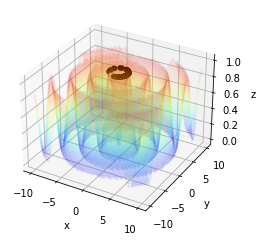

In [21]:
def schaffer_function_plot(x,y):
    g = 0.5 + (np.power((np.sin( np.sqrt( np.power(x, 2) + np.power(y, 2)))), 2) - 0.5)/ \
        (1 + 0.001 * (np.power(x, 2) + np.power(y, 2)))
    return g

value_ranges = np.array([[-10,10], [-10,10]])
min_mat = value_ranges.T[0, :]
max_mat = value_ranges.T[1,:]
best_solutions_denorm = best_solutions * (max_mat - min_mat) + min_mat


x_data = best_solutions_denorm[:, 0]
y_data = best_solutions_denorm[:, 1]
z_data = schaffer_function_plot(x_data, y_data)
x = np.linspace(-10, 10, 50)
y = np.linspace(-10, 10, 50)

X, Y = np.meshgrid(x, y)
Z = schaffer_function_plot(X, Y)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='jet', alpha=0.1)
ax.scatter3D(x_data, y_data, z_data, c=z_data, cmap='binary', alpha=1)
#ax.set_xlim3d(-10,10)
#ax.set_ylim3d(-10,10)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')


MovieWriter imagemagick unavailable; using Pillow instead.


Global optimal at f([-0.30303030303030276, -3.1313131313131315])=0.004918708674121586


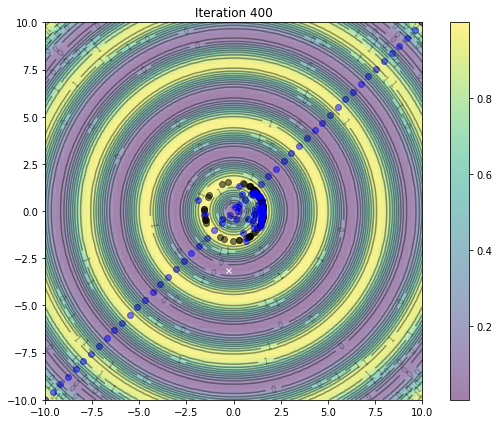

In [29]:
# Compute and plot the function in 3D within [0,5]x[0,5]
x, y = np.array(np.meshgrid(np.linspace(-10,10,100), np.linspace(-10,10,100)))
z = schaffer_function_plot(x, y)
x_min = x.ravel()[z.argmin()]
y_min = y.ravel()[z.argmin()]

particles = depso.particle_history
pbests = depso.pbest_history
gbests = depso.gbest_history
speeds = depso.speed_history

fig, ax = plt.subplots(figsize=(8,6))
fig.set_tight_layout(True)
img = ax.imshow(z, extent=[-10, 10, -10, 10], origin='lower', cmap='viridis', alpha=0.5)
fig.colorbar(img, ax=ax)
ax.plot([x_min], [y_min], marker='x', markersize=5, color="white")
contours = ax.contour(x, y, z, 10, colors='black', alpha=0.4)
ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
#p_plot = ax.scatter(X[0], X[1], marker='o', color='blue', alpha=0.5)
pbest_plot = ax.scatter(pbests[0][:,0],pbests[0][:,1], marker='o', color='black', alpha=0.5)
p_plot = ax.scatter(particles[0][:,0], particles[0][:,1], marker='o', color='blue', alpha=0.5)
p_arrow = ax.quiver(particles[0][:,0], particles[0][:,1], speeds[0][:,0], speeds[1][:,1], color='blue', width=0.005, angles='xy', scale_units='xy', scale=1)
gbest_plot = plt.scatter([gbests[0][0]], [gbests[0][1]], marker='*', s=100, color='black', alpha=0.4)

ax.set_xlim([-10,10])
ax.set_ylim([-10,10])


def animate(i):
    "Steps of PSO: algorithm update and show in plot"
    title = 'Iteration {:02d}'.format(i)
    ax.set_title(title)
    pbest_plot.set_offsets(pbests[i])
    p_plot.set_offsets(particles[i])
    p_arrow.set_offsets(particles[i])
    p_arrow.set_UVC(speeds[i][:,0], speeds[i][:,1])
    gbest_plot.set_offsets(gbests[i].reshape(1,-1))
    return ax, pbest_plot, p_plot, p_arrow, gbest_plot
    #return ax, p_plot

anim = FuncAnimation(fig, animate, frames=list(range(1,len(particles)-2)), interval=50, blit=False, repeat=True)
anim.save("depso.gif", dpi=120, writer="imagemagick")

#print("PSO found best solution at f({})={}".format(gbest, gbest_obj))
print("Global optimal at f({})={}".format([x_min,y_min], schaffer_function_plot(x_min,y_min)))
#HTML(anim.to_jshtml())


In [28]:
len(particles)

403